**Experiment 1**

In [1]:
#Cell 1 — Install dependencies
!pip -q install opacus==1.4.0 tqdm pandas matplotlib torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 25.1 MB/s eta 0:00:00


In [2]:
#Cell 2 — Imports + reproducibility
import os, math, random, re, subprocess
from copy import deepcopy
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

from opacus.accountants import RDPAccountant

# Wider alpha grid => avoids "optimal order is the largest alpha" warning
RDP_ALPHAS = (
    [1.01, 1.05] +
    [1.1 + 0.1*i for i in range(0, 90)] +      # 1.1..10.0
    list(range(11, 64)) + [64, 128, 256, 512]
)

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [3]:
#Cell 3 — Download Fashion‑MNIST
#torchvision downloads it automatically.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_ds = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_ds = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
print(len(train_ds), len(test_ds))

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.48MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:04<00:00, 998kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.0MB/s]

60000 10000


In [4]:
#Cell 4 — Make 6000 clients × 10 samples/client (FedVRDP-style)
def make_cross_device_clients(train_dataset, num_clients=6000, samples_per_client=10, seed=0):
    assert num_clients * samples_per_client <= len(train_dataset)
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(train_dataset)).tolist()
    clients = []
    for c in range(num_clients):
        clients.append(idx[c*samples_per_client:(c+1)*samples_per_client])
    return clients

clients = make_cross_device_clients(train_ds, num_clients=6000, samples_per_client=10, seed=0)
print("num clients:", len(clients), "samples/client:", len(clients[0]))

num clients: 6000 samples/client: 10


In [5]:
#Cell 5 — Optional “public anchor set” (2 samples/class)
#This mirrors the idea “tiny auxiliary data is easy to obtain” used by Xiang et al
#If we want to skip this, set public_idx = [] and don’t filter.
def extract_public_per_class(dataset, per_class=2, seed=0):
    rng = np.random.default_rng(seed)
    targets = np.array(dataset.targets)
    public_idx = []
    for k in range(10):
        cls_idx = np.where(targets == k)[0]
        rng.shuffle(cls_idx)
        public_idx.extend(cls_idx[:per_class].tolist())
    public_idx = sorted(public_idx)
    return public_idx

public_idx = extract_public_per_class(train_ds, per_class=2, seed=0)
public_loader = DataLoader(Subset(train_ds, public_idx), batch_size=20, shuffle=False)

# Remove public samples from clients so they are not used privately
public_set = set(public_idx)
clients_wo_public = []
for cid in range(len(clients)):
    filtered = [i for i in clients[cid] if i not in public_set]
    clients_wo_public.append(filtered)

clients = clients_wo_public
print("public samples:", len(public_idx), "| example client size after removal:", len(clients[0]))

public samples: 20 | example client size after removal: 10


In [6]:
#Cell 6 — Model (CNN like FedVRDP description)
#FedVRDP describes a CNN with 2 conv layers, maxpool, ReLU, FC(512).
class FMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # 28->24
        x = F.max_pool2d(x, 2)          # 24->12
        x = F.relu(self.conv2(x))       # 12->8
        x = F.max_pool2d(x, 2)          # 8->4
        x = x.view(x.size(0), -1)       # 64*4*4
        x = F.relu(self.fc1(x))
        return self.fc2(x)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

In [7]:
#Cell 7 — Tensor-list utilities (fast, no giant flatten)
def model_param_list(model):
    return [p for p in model.parameters() if p.requires_grad]

@torch.no_grad()
def zero_like_params(model):
    return [torch.zeros_like(p) for p in model_param_list(model)]

@torch.no_grad()
def add_update_(model, update_list, scale=1.0):
    for p, u in zip(model_param_list(model), update_list):
        p.data.add_(u, alpha=scale)

@torch.no_grad()
def l2_norm_list(tlist):
    s = None
    for t in tlist:
        v = (t*t).sum()
        s = v if s is None else s + v
    return torch.sqrt(s + 1e-12)

@torch.no_grad()
def dot_list(a_list, b_list):
    s = None
    for a, b in zip(a_list, b_list):
        v = (a*b).sum()
        s = v if s is None else s + v
    return s

@torch.no_grad()
def add_scaled_list_(dst, src, alpha):
    for d, s in zip(dst, src):
        d.add_(s, alpha=alpha)

@torch.no_grad()
def sub_list(a, b):
    return [x - y for x, y in zip(a, b)]

In [8]:
#Cell 8 — Local client training (returns update = local_model − global_model)
def client_update(global_model, client_indices, lr, momentum, local_epochs, batch_size=10):
    local_model = deepcopy(global_model)
    local_model.train()

    loader = DataLoader(Subset(train_ds, client_indices),
                        batch_size=batch_size, shuffle=True, drop_last=False)

    opt = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(local_epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(local_model(x), y)
            loss.backward()
            opt.step()

    # delta = local - global
    delta = []
    for lp, gp in zip(model_param_list(local_model), model_param_list(global_model)):
        delta.append((lp.data - gp.data).detach())
    return delta

In [9]:
#Cell 9 — DP accounting helpers (compute noise multiplier for target ε)
#We will use RDP accountant_toggle: sample rate  𝑞=clients per round/total clients, steps = rounds.

# Cell 9 — DP accounting helpers (Opacus 1.4.0 compatible)

from opacus.accountants import RDPAccountant

def epsilon_from_sigma_dp_sgd(sigma, q, steps, delta):
    acc = RDPAccountant()  # <-- no alphas here
    for _ in range(steps):
        acc.step(noise_multiplier=sigma, sample_rate=q)
    return acc.get_epsilon(delta)

def epsilon_from_sigma_two_mech(sigma_sel, sigma_rel, q, steps, delta):
    acc = RDPAccountant()  # <-- no alphas here
    for _ in range(steps):
        acc.step(noise_multiplier=sigma_sel, sample_rate=q)  # selection
        acc.step(noise_multiplier=sigma_rel, sample_rate=q)  # release
    return acc.get_epsilon(delta)

def find_sigma_for_target_eps_single(target_eps, q, steps, delta, lo=0.1, hi=80.0, iters=40):
    for _ in range(iters):
        mid = (lo + hi) / 2
        eps = epsilon_from_sigma_dp_sgd(mid, q, steps, delta)
        if eps > target_eps:
            lo = mid
        else:
            hi = mid
    return hi

def find_sigma_for_target_eps_two(target_eps, q, steps, delta, sel_factor=4.0, lo=0.1, hi=200.0, iters=40):
    for _ in range(iters):
        mid = (lo + hi) / 2
        eps = epsilon_from_sigma_two_mech(sel_factor*mid, mid, q, steps, delta)
        if eps > target_eps:
            lo = mid
        else:
            hi = mid
    return hi

def report_noise_scales(target_eps, q, rounds, delta, C, M, rho, tau, sel_factor):
    nm_fedavg = find_sigma_for_target_eps_single(target_eps, q, rounds, delta)
    nm_rel    = find_sigma_for_target_eps_two(target_eps, q, rounds, delta, sel_factor=sel_factor)
    nm_sel    = sel_factor * nm_rel

    noise_mean = nm_fedavg * (C / M)     # DP-FedAvg released mean noise std
    noise_rel  = nm_rel * (rho / tau)    # AG-PTR released update noise std (conservative, denom>=tau)

    achieved = epsilon_from_sigma_two_mech(nm_sel, nm_rel, q, rounds, delta)

    print(f"Target eps_total = {target_eps}")
    print(f"q={q:.4f}, rounds={rounds}, delta={delta}")
    print(f"[DP-FedAvg] nm={nm_fedavg:.4f}  -> noise_std_on_mean = {noise_mean:.6g} (C/M)")
    print(f"[AG-PTR]   nm_sel={nm_sel:.4f}")
    print(f"[AG-PTR]   nm_rel={nm_rel:.4f} -> noise_std_on_release ≈ {noise_rel:.6g} (rho/tau)")
    print(f"[AG-PTR] achieved eps ≈ {achieved:.3f} (target {target_eps})")
    print(f"Noise ratio (AG-PTR / FedAvg) = {noise_rel/(noise_mean+1e-12):.3f}")




In [10]:
#Cell 10 — DP‑FedAvg training loop
def train_dp_fedavg(seed, eps_total, delta=1e-5,
                    num_clients=6000, clients_per_round=100,
                    rounds=180, local_epochs=10, batch_size=10,
                    lr0=0.125, lr_decay=0.99, momentum=0.5,
                    clip_C=1.0):

    seed_all(seed)
    model = FMNIST_CNN().to(device)
    q = clients_per_round / num_clients

    sigma = find_sigma_for_target_eps_single(eps_total, q, rounds, delta)
    achieved_eps = epsilon_from_sigma_dp_sgd(sigma, q, rounds, delta)

    mean_noise_std = sigma * (clip_C / clients_per_round)
    print(f"[DP-FedAvg] target eps={eps_total} -> nm={sigma:.4f}, achieved eps≈{achieved_eps:.3f}, mean-noise-std≈{mean_noise_std:.6g}")

    for t in tqdm(range(rounds), desc=f"DP-FedAvg eps={eps_total}"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = np.random.choice(num_clients, size=clients_per_round, replace=False)

        sum_update = zero_like_params(model)

        for cid in chosen:
            delta_i = client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                                    local_epochs=local_epochs, batch_size=batch_size)

            norm = l2_norm_list(delta_i)
            scale = min(1.0, clip_C / (norm.item() + 1e-12))
            add_scaled_list_(sum_update, delta_i, scale)

        # add Gaussian noise to the SUM (std = sigma * C)
        for j in range(len(sum_update)):
            sum_update[j].add_(torch.randn_like(sum_update[j]) * (sigma * clip_C))

        avg_update = [u / clients_per_round for u in sum_update]
        add_update_(model, avg_update, scale=1.0)

    acc = evaluate(model, test_loader)
    return acc, achieved_eps, sigma


In [11]:
#Cell 11 — Minimal AG‑PTR training loop (efficient R=2 anchors: ±previous_update)
#This is a “minimal but faithful” implementation for Experiment 1:

def train_ag_ptr(seed, eps_total, delta=1e-5,
                 num_clients=6000, clients_per_round=100,
                 rounds=180, local_epochs=10, batch_size=10,
                 lr0=0.125, lr_decay=0.99, momentum=0.5,
                 rho=0.3, tau=60, sel_factor=4.0):

    """
    Minimal AG-PTR for Exp1 with R=2 anchors (+a and -a), but optimized runtime:
    - Cache deltas for sampled clients so we don't train them twice.
    """

    seed_all(seed)
    model = FMNIST_CNN().to(device)
    q = clients_per_round / num_clients

    sigma_rel = find_sigma_for_target_eps_two(eps_total, q, rounds, delta, sel_factor=sel_factor)
    sigma_sel = sel_factor * sigma_rel
    achieved_eps = epsilon_from_sigma_two_mech(sigma_sel, sigma_rel, q, rounds, delta)
    print(f"[AG-PTR] target eps={eps_total} -> sigma_rel={sigma_rel:.4f}, sigma_sel={sigma_sel:.4f}, achieved eps≈{achieved_eps:.3f}")

    anchor = zero_like_params(model)  # list-of-tensors
    accept_count = 0

    for t in tqdm(range(rounds), desc=f"AG-PTR eps={eps_total}"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = np.random.choice(num_clients, size=clients_per_round, replace=False)

        # ---- Compute each sampled client update ONCE (cache) ----
        deltas = []
        scores = []  # dot(delta_i, anchor)
        for cid in chosen:
            delta_i = client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                                    local_epochs=local_epochs, batch_size=batch_size)
            deltas.append(delta_i)
            scores.append(dot_list(delta_i, anchor).item())

        # ---- Phase 1: DP noisy selection between +anchor and -anchor ----
        count_pos = sum(1 for s in scores if s >= 0)
        count_neg = clients_per_round - count_pos

        noisy_pos = count_pos + np.random.normal(0.0, sigma_sel)
        noisy_neg = count_neg + np.random.normal(0.0, sigma_sel)

        select_pos = (noisy_pos >= noisy_neg)
        noisy_winner = noisy_pos if select_pos else noisy_neg

        if noisy_winner < tau:
            # reject: no update released
            continue

        accept_count += 1
        chosen_anchor = anchor if select_pos else [(-a) for a in anchor]

        # ---- Phase 2: release anchored mean of clipped offsets (only winners contribute) ----
        sum_offsets = zero_like_params(model)
        contributors = 0

        for delta_i, s in zip(deltas, scores):
            assigned_pos = (s >= 0)
            if assigned_pos != select_pos:
                continue
            contributors += 1

            offset = sub_list(delta_i, chosen_anchor)
            off_norm = l2_norm_list(offset).item()
            scale = min(1.0, rho / (off_norm + 1e-12))
            add_scaled_list_(sum_offsets, offset, scale)

        m_hat = max(float(tau), float(noisy_winner))  # DP-safe denominator (post-processing of DP count)

        # add DP Gaussian noise to SUM offsets (std = sigma_rel * rho)
        for j in range(len(sum_offsets)):
            sum_offsets[j].add_(torch.randn_like(sum_offsets[j]) * (sigma_rel * rho))

        mean_update = [ca + (so / m_hat) for ca, so in zip(chosen_anchor, sum_offsets)]

        # apply update
        add_update_(model, mean_update, scale=1.0)

        # update anchor using the released update (DP-safe by post-processing)
        anchor = [u.detach() for u in mean_update]

    acc = evaluate(model, test_loader)
    accept_rate = accept_count / rounds
    return acc, achieved_eps, (sigma_sel, sigma_rel), accept_rate



In [12]:
# Cell 12 — Run the Experiment 1 core sweep (DP‑FedAvg + AG‑PTR) and save core CSV

EPS_GRID = [1, 2, 4]
SEEDS = [1, 2, 3]

DELTA = 1e-5
ROUNDS = 180
NUM_CLIENTS = 6000
CLIENTS_PER_ROUND = 100
LOCAL_EPOCHS = 10
BATCH_SIZE = 10
LR0 = 0.125
LR_DECAY = 0.99
MOMENTUM = 0.5

CLIP_C = 1.0
RHO = 0.3
TAU = 60
SEL_FACTOR = 4.0

# Sanity: print the REAL noise-on-release comparison
q = CLIENTS_PER_ROUND / NUM_CLIENTS
for eps in EPS_GRID:
    report_noise_scales(eps, q, ROUNDS, DELTA, C=CLIP_C, M=CLIENTS_PER_ROUND, rho=RHO, tau=TAU, sel_factor=SEL_FACTOR)
    print("")

rows = []

for eps in EPS_GRID:
    # DP-FedAvg
    accs = []
    for sd in SEEDS:
        acc, achieved_eps, sigma = train_dp_fedavg(
            sd, eps, delta=DELTA,
            num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
            rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
            lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
            clip_C=CLIP_C
        )
        accs.append(acc)
    rows.append({
        "method": "DP-FedAvg",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
    })

    # AG-PTR
    accs = []
    acc_rates = []
    for sd in SEEDS:
        acc, achieved_eps, (sig_sel, sig_rel), ar = train_ag_ptr(
            sd, eps, delta=DELTA,
            num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
            rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
            lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
            rho=RHO, tau=TAU, sel_factor=SEL_FACTOR
        )
        accs.append(acc)
        acc_rates.append(ar)
    rows.append({
        "method": "AG-PTR",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
        "accept_rate_mean": float(np.mean(acc_rates)),
    })

df_core = pd.DataFrame(rows)
print(df_core)

os.makedirs("results", exist_ok=True)
core_path = "results/exp1_core.csv"
df_core.to_csv(core_path, index=False)
print("Saved:", core_path)



/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Target eps_total = 1
q=0.0167, rounds=180, delta=1e-05
[DP-FedAvg] nm=1.3142  -> noise_std_on_mean = 0.0131425 (C/M)
[AG-PTR]   nm_sel=5.2895
[AG-PTR]   nm_rel=1.3224 -> noise_std_on_release ≈ 0.00661182 (rho/tau)
[AG-PTR] achieved eps ≈ 1.000 (target 1)
Noise ratio (AG-PTR / FedAvg) = 0.503

Target eps_total = 2
q=0.0167, rounds=180, delta=1e-05
[DP-FedAvg] nm=0.9713  -> noise_std_on_mean = 0.00971334 (C/M)
[AG-PTR]   nm_sel=3.8944
[AG-PTR]   nm_rel=0.9736 -> noise_std_on_release ≈ 0.00486804 (rho/tau)
[AG-PTR] achieved eps ≈ 2.000 (target 2)
Noise ratio (AG-PTR / FedAvg) = 0.501

Target eps_total = 4
q=0.0167, rounds=180, delta=1e-05
[DP-FedAvg] nm=0.7472  -> noise_std_on_mean = 0.00747219 (C/M)
[AG-PTR]   nm_sel=2.9922
[AG-PTR]   nm_rel=0.7481 -> noise_std_on_release ≈ 0.00374029 (rho/tau)
[AG-PTR] achieved eps ≈ 4.000 (target 4)
Noise ratio (AG-PTR / FedAvg) = 0.501

[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:45<00:00,  2.25s/it]


[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:52<00:00,  2.29s/it]


[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:58<00:00,  2.33s/it]


[AG-PTR] target eps=1 -> sigma_rel=1.3224, sigma_sel=5.2895, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


[AG-PTR] target eps=1 -> sigma_rel=1.3224, sigma_sel=5.2895, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 180/180 [06:46<00:00,  2.26s/it]


[AG-PTR] target eps=1 -> sigma_rel=1.3224, sigma_sel=5.2895, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 180/180 [06:44<00:00,  2.25s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [06:56<00:00,  2.31s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [07:04<00:00,  2.36s/it]


[AG-PTR] target eps=2 -> sigma_rel=0.9736, sigma_sel=3.8944, achieved eps≈2.000


AG-PTR eps=2: 100%|██████████| 180/180 [06:33<00:00,  2.19s/it]


[AG-PTR] target eps=2 -> sigma_rel=0.9736, sigma_sel=3.8944, achieved eps≈2.000


AG-PTR eps=2: 100%|██████████| 180/180 [06:24<00:00,  2.14s/it]


[AG-PTR] target eps=2 -> sigma_rel=0.9736, sigma_sel=3.8944, achieved eps≈2.000


AG-PTR eps=2: 100%|██████████| 180/180 [06:26<00:00,  2.15s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:32<00:00,  2.18s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:37<00:00,  2.21s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:33<00:00,  2.18s/it]


[AG-PTR] target eps=4 -> sigma_rel=0.7481, sigma_sel=2.9922, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 180/180 [06:31<00:00,  2.18s/it]


[AG-PTR] target eps=4 -> sigma_rel=0.7481, sigma_sel=2.9922, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 180/180 [06:30<00:00,  2.17s/it]


[AG-PTR] target eps=4 -> sigma_rel=0.7481, sigma_sel=2.9922, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 180/180 [06:40<00:00,  2.23s/it]


      method  eps_target  acc_mean   acc_std  accept_rate_mean
0  DP-FedAvg           1  0.729100  0.004445               NaN
1     AG-PTR           1  0.543800  0.098825          0.883333
2  DP-FedAvg           2  0.777500  0.002393               NaN
3     AG-PTR           2  0.649333  0.015137          0.848148
4  DP-FedAvg           4  0.805500  0.002963               NaN
5     AG-PTR           4  0.676267  0.005681          0.809259
Saved: results/exp1_core.csv


Saved: results/exp1_privacy_utility.csv


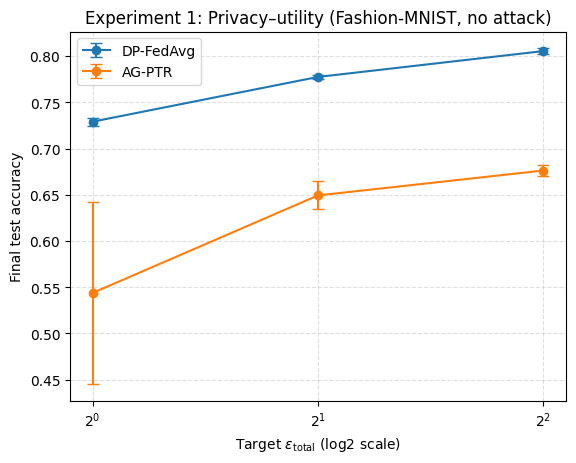

Saved: results/exp1_privacy_utility.png


In [15]:
# Cell 13 — Save CSV + plot accuracy vs epsilon
import os
import matplotlib.pyplot as plt

# Save CSV
os.makedirs("results", exist_ok=True)
csv_path = "results/exp1_privacy_utility.csv"
df_core.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Plot
plt.figure()
for method in df_core["method"].unique():
    sub = df_core[df_core["method"] == method].sort_values("eps_target")
    plt.errorbar(
        sub["eps_target"],
        sub["acc_mean"],
        yerr=sub["acc_std"],
        marker="o",
        capsize=4,
        label=method
    )

plt.xscale("log", base=2)
plt.xlabel(r"Target $\varepsilon_{\mathrm{total}}$ (log2 scale)")
plt.ylabel("Final test accuracy")
plt.title("Experiment 1: Privacy–utility (Fashion-MNIST, no attack)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

fig_path = "results/exp1_privacy_utility.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig_path)


In [16]:
# cell 14 - PDPBRFL. (official repo) — “no attack” run
# --- Clone + install ---
%cd /content
!rm -rf Practical-Differentially-Private-and-Byzantine-resilient-Federated
!git clone https://github.com/zihangxiang/Practical-Differentially-Private-and-Byzantine-resilient-Federated
%cd Practical-Differentially-Private-and-Byzantine-resilient-Federated
!pip -q install -r requirements.txt

# --- Runner + parser ---
import re, subprocess, pandas as pd, numpy as np, os

def run_cmd_capture(cmd, log_path):
    p = subprocess.run(cmd, text=True, capture_output=True)
    out = p.stdout + "\n" + p.stderr
    with open(log_path, "w") as f:
        f.write(out)
    return out

def parse_test_acc(text):
    t = text.lower()
    pats = [
        r"test[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"final[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"best[^0-9a-z]*test[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
    ]
    for pat in pats:
        ms = re.findall(pat, t)
        if ms:
            return float(ms[-1])
    return None

EPS_GRID = [1, 2, 4]
SEEDS = [1, 2, 3]

os.makedirs("/content/results", exist_ok=True)
rows = []

for eps in EPS_GRID:
    accs = []
    for sd in SEEDS:
        log_path = f"/content/results/xiang_eps{eps}_seed{sd}.log"
        cmd = [
            "python", "main.py",
            "--dataset", "fashion",
            "--att_key", "nobyz",
            "--epsilon", str(eps),
            "--DP_mode", "centralDP",
            "--seed", str(sd),
            "--mal_worker_portion", "0",
            "--anti_byz", "1",
            "--non_iid", "0",
            "--start_att", "0.0",
            "--base_lr", "0.2"
        ]
        out = run_cmd_capture(cmd, log_path)
        acc = parse_test_acc(out)
        if acc is None:
            print(f"[Xiang] Could not parse accuracy from {log_path}. Showing last 40 lines:")
            print("\n".join(out.splitlines()[-40:]))
            raise RuntimeError("Parsing failed; adjust parse_test_acc() patterns to match their output.")
        accs.append(acc)

    rows.append({
        "method": "Xiang-et-al",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
    })

df_x = pd.DataFrame(rows)
df_x.to_csv("/content/results/exp1_xiang.csv", index=False)
print(df_x)
print("Saved: /content/results/exp1_xiang.csv")


/content
Cloning into 'Practical-Differentially-Private-and-Byzantine-resilient-Federated'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 48 (delta 2), reused 4 (delta 2), pack-reused 37 (from 1)
Receiving objects: 100% (48/48), 6.47 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/Practical-Differentially-Private-and-Byzantine-resilient-Federated
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following yanked versions: 2.4.0
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.

RuntimeError: Parsing failed; adjust parse_test_acc() patterns to match their output.

In [17]:
# Cell 15 Because the DP‑BREM repo doesn’t document exact CLI flags in the README,
#this cell first prints args/help, then gives you a runnable scaffold + the same “parse into CSV” logic:
%cd /content
!rm -rf DP-BREM
!git clone https://github.com/xiaolangu/DP-BREM.git
%cd DP-BREM

# Inspect available CLI args (copy the right flags into the command below)
!python main.py --help || true
!sed -n '1,220p' args.py


/content
Cloning into 'DP-BREM'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 28 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 22.36 KiB | 11.18 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/DP-BREM
2026-02-13 10:05:35.051276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 10:05:35.063222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770977135.078265   45209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDN

In [18]:
#cell 16  once you see the real flags (dataset name, epsilon flag, byzantine ratio flag, etc.).
# After  edit the cmd = [...] list to match DP‑BREM’s argparse, the rest will auto-sweep eps/seeds and write results/exp1_dpbrem.csv
import re, subprocess, pandas as pd, numpy as np, os

def run_cmd_capture(cmd, log_path):
    p = subprocess.run(cmd, text=True, capture_output=True)
    out = p.stdout + "\n" + p.stderr
    with open(log_path, "w") as f:
        f.write(out)
    return out

def parse_test_acc(text):
    t = text.lower()
    pats = [
        r"test[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"final[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"avg[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
    ]
    for pat in pats:
        ms = re.findall(pat, t)
        if ms:
            return float(ms[-1])
    return None

EPS_GRID = [1, 2, 4]
SEEDS = [1, 2, 3]

os.makedirs("/content/results", exist_ok=True)
rows = []

for eps in EPS_GRID:
    accs = []
    for sd in SEEDS:
        log_path = f"/content/results/dpbrem_eps{eps}_seed{sd}.log"

        # TODO: EDIT THESE FLAGS to match DP-BREM's args.py
        cmd = [
            "python", "main.py",
            "--dataset", "fashionmnist",     # <-- change if needed (e.g., fmnist)
            "--epsilon", str(eps),           # <-- change if needed (e.g., --eps)
            "--seed", str(sd),
            "--byz_frac", "0.0",             # <-- change flag name; set 0 attack
            "--attack", "none",              # <-- change if needed
        ]

        out = run_cmd_capture(cmd, log_path)
        acc = parse_test_acc(out)
        if acc is None:
            print(f"[DP-BREM] Could not parse accuracy from {log_path}. Showing last 60 lines:")
            print("\n".join(out.splitlines()[-60:]))
            raise RuntimeError("Parsing failed; adjust cmd flags + parse_test_acc() patterns.")

        accs.append(acc)

    rows.append({
        "method": "DP-BREM",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
    })

df_b = pd.DataFrame(rows)
df_b.to_csv("/content/results/exp1_dpbrem.csv", index=False)
print(df_b)
print("Saved: /content/results/exp1_dpbrem.csv")


[DP-BREM] Could not parse accuracy from /content/results/dpbrem_eps1_seed1.log. Showing last 60 lines:

2026-02-13 10:06:27.883968: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 10:06:27.896555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770977187.911261   45539 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770977187.915910   45539 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770977187.928789   45539 c

RuntimeError: Parsing failed; adjust cmd flags + parse_test_acc() patterns.

In [ ]:
#cell 17 merge
# Cell 13 — Merge external baseline results (Xiang, DP-BREM/+) + plot

# 1) Fill these after you run the official repos.
# Put mean/std over the same 3 seeds for eps=1,2,4.
external_rows = [
    # {"method": "Xiang-et-al", "eps_target": 1, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "Xiang-et-al", "eps_target": 2, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "Xiang-et-al", "eps_target": 4, "acc_mean": 0.0, "acc_std": 0.0},

    # {"method": "DP-BREM",   "eps_target": 1, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "DP-BREM",   "eps_target": 2, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "DP-BREM",   "eps_target": 4, "acc_mean": 0.0, "acc_std": 0.0},

    # If you also run DP-BREM+ separately, add it as its own method label:
    # {"method": "DP-BREM+",  "eps_target": 1, "acc_mean": 0.0, "acc_std": 0.0},
]

df_ext = pd.DataFrame(external_rows) if len(external_rows) else pd.DataFrame(columns=df_core.columns)

# Combine
df_all = pd.concat([df_core, df_ext], ignore_index=True, sort=False)

all_path = "results/exp1_all.csv"
df_all.to_csv(all_path, index=False)
print("Saved:", all_path)
print(df_all)

# Plot
plt.figure()
for method in df_all["method"].unique():
    sub = df_all[df_all["method"] == method].sort_values("eps_target")
    if len(sub) == 0:
        continue
    yerr = sub["acc_std"] if "acc_std" in sub.columns else None
    plt.errorbar(sub["eps_target"], sub["acc_mean"], yerr=yerr, marker="o", capsize=4, label=method)

plt.xscale("log", base=2)
plt.xlabel(r"Target $\varepsilon_{\mathrm{total}}$ (log2 scale)")
plt.ylabel("Final test accuracy")
plt.title("Experiment 1: Privacy–utility (Fashion-MNIST, no attack)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

fig_path = "results/exp1_privacy_utility.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig_path)

